# Attention U-Net

## Attention Gate

Attention gate takes 2 inputs.
1. gating signal (g)
2. skip connection (x)

g: g comes from the next lowest layer of the network. Since it comes from the deeper part of the network it has better feature representation.

x: x comes from skip connections. Since it comes from the early layers, it has better spatial information.

### Working:
1. The first step is to add g and x. Since both are of different dimensions, make them to same dimensions and add. The addition makes the aligned weights larger while unaligned weights get relatively smaller.
For example,

g -> 64 X 64 X 64    -> 1 X 1, stride=(1,1), n_filters=128 -> 64 X 64 X 128

x -> 128 X 128 X 128 -> 1 X 1, stride=(2,2), n_filters=128 -> 64 X 64 X 128

2. Apply ReLU activation function.

3. Apply 1 X 1 filter convolution with 1 filter. So, that feature dimension will be 1.
64 X 64 X 128 -> 1 X 1, n_filters=1 -> 64 X 64 X 1

4. Apply sigmoid activation function. It scales all weights to between 0 and 1.

5. Upsample to original size (128 X 128). These are the learnable weights.

6. Perform element-wise multiplication with the original x vector. This scales the vector based on relevance.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/isbi-2012-challenge/test-labels.tif
/kaggle/input/isbi-2012-challenge/train-volume.tif
/kaggle/input/isbi-2012-challenge/challenge-error-metrics.bsh
/kaggle/input/isbi-2012-challenge/test-volume.tif
/kaggle/input/isbi-2012-challenge/train-labels.tif


In [2]:
# General
import torch
import numpy as np
import matplotlib.pyplot as plt

# For dataloading
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For architecture and training
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class ISBIDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.images = tiff.imread(image_path).astype(np.float32)
        self.masks = tiff.imread(mask_path).astype(np.float32)
        self.transform = transform

        # Normalize images and masks to [0, 1]
        self.images = (self.images - np.min(self.images)) / (np.max(self.images) - np.min(self.images))
        self.masks = self.masks / 255.0

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def __len__(self):
        return len(self.images)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ISBIDataset(
    image_path="/kaggle/input/isbi-2012-challenge/train-volume.tif",
    mask_path="/kaggle/input/isbi-2012-challenge/train-labels.tif",
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True
)

In [6]:
def show_pair(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

Number of training pairs: 30
Number of training batches: 8
Image batch shape: torch.Size([4, 1, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


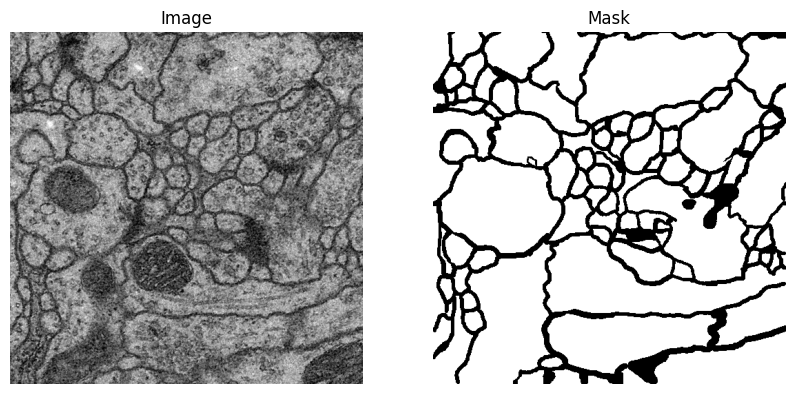

In [7]:
print(f'Number of training pairs: {len(train_dataset)}')
print(f'Number of training batches: {len(train_loader)}')

for image, mask in train_loader:
    print(f'Image batch shape: {image.shape}')
    print(f'Mask batch shape: {mask.shape}')

    show_pair(image[0], mask[0])

    break

In [28]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x
    
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x
    
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=1, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

In [29]:
# Training and evaluation
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score

In [31]:
def calculate_metrics(preds, labels):
    preds = torch.sigmoid(preds).data.cpu().numpy()
    preds = (preds > 0.5).astype(np.uint8)
    labels = labels.data.cpu().numpy().astype(np.uint8)

    accuracy = accuracy_score(labels.flatten(), preds.flatten())
    iou = jaccard_score(labels.flatten(), preds.flatten(), average='binary')
    return accuracy, iou

In [32]:
model = AttentionUNet().cuda()
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy with logits for binary segmentation
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20

In [33]:
print('Starting Training...')
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_iou = 0
    for images, masks in train_loader:
        images = images.cuda()
        masks = masks.cuda()
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        accuracy, iou = calculate_metrics(outputs, masks)
        epoch_accuracy += accuracy
        epoch_iou += iou
    
    avg_loss = epoch_loss / len(train_loader)
    avg_accuracy = epoch_accuracy / len(train_loader)
    avg_iou = epoch_iou / len(train_loader)
    
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    train_ious.append(avg_iou)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, IoU: {avg_iou:.4f}")

print("Training complete.")


Starting Training...
Epoch [1/20], Loss: 0.4911, Accuracy: 0.7826, IoU: 0.7421
Epoch [2/20], Loss: 0.3408, Accuracy: 0.8803, IoU: 0.8572
Epoch [3/20], Loss: 0.2951, Accuracy: 0.8958, IoU: 0.8759
Epoch [4/20], Loss: 0.2747, Accuracy: 0.8987, IoU: 0.8793
Epoch [5/20], Loss: 0.2623, Accuracy: 0.8988, IoU: 0.8796
Epoch [6/20], Loss: 0.2451, Accuracy: 0.9051, IoU: 0.8865
Epoch [7/20], Loss: 0.2279, Accuracy: 0.9112, IoU: 0.8931
Epoch [8/20], Loss: 0.2269, Accuracy: 0.9093, IoU: 0.8906
Epoch [9/20], Loss: 0.2155, Accuracy: 0.9130, IoU: 0.8954
Epoch [10/20], Loss: 0.2122, Accuracy: 0.9139, IoU: 0.8963
Epoch [11/20], Loss: 0.1999, Accuracy: 0.9185, IoU: 0.9010
Epoch [12/20], Loss: 0.2003, Accuracy: 0.9178, IoU: 0.9000
Epoch [13/20], Loss: 0.2001, Accuracy: 0.9166, IoU: 0.8991
Epoch [14/20], Loss: 0.1953, Accuracy: 0.9183, IoU: 0.9006
Epoch [15/20], Loss: 0.1937, Accuracy: 0.9198, IoU: 0.9022
Epoch [16/20], Loss: 0.2026, Accuracy: 0.9132, IoU: 0.8954
Epoch [17/20], Loss: 0.1956, Accuracy: 0.917

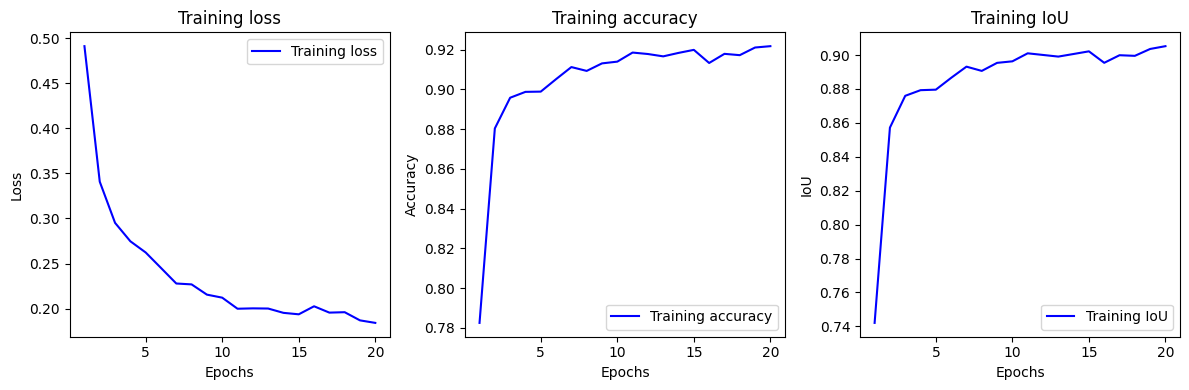

In [34]:
# Plotting the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_ious, 'b', label='Training IoU')
plt.title('Training IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()